# Generation of novel views from files .obj .off 
Here from file **.obj .off .stl .ply** we generate a novel dataset to evaluate ours models with respect to the ground truth point cloud.

Pipeline of this notebook:
- extract the meshes from the files  **.obj .off .stl .ply**
- sample the mesh and generate the ground truth point cloud of the object
- generate automatically multiple views without warp the object 
    + the object is centered towards the offset
    + each pose has the same light setting
    + each pose do not have shadows or reflections
    + fixing the camera elevation and distance from the scene we keep pic of the scene from different perspective
    

In [1]:
import torch
from google.colab import files

# add path for demo utils functions
import os
import sys

# install the latest release of PyTorch3D
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'



from scipy.spatial import distance
import tqdm
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Util function for loading meshes
import pytorch3d
from pytorch3d.io import load_objs_as_meshes, load_obj
# Data structures and functions for rendering
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance
from pytorch3d.structures import Meshes
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    SoftSilhouetteShader,
    TexturesVertex,
    HardPhongShader
)

!pip install trimesh # install trimesh
import glob
import trimesh
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

from tqdm import tqdm
from PIL import Image, ImageDraw
from pytorch3d.io import IO

# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 987.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 sha256=3161a2fc9c9837c6aa027d78c66735752b8d6f2ddcdcbe7df7e54d56e9a7af67
  Stored in directory: /root/.cache/pip/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=cc55a98cfdd2d65a1030af09c8fdf6308313f31bd4d8a7ffb810e02ee299c4a4
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu116_pyt1131/do

*We found different object on the internet. Thus, we produced the sampled version of the object (the generated points are uniformly distributed). Here we can visualize the point clouds generated filling the values of the colors that are missing with random values.*

In [ ]:
# Data dir
DATA_DIR = "./data/"
obj_filename = os.path.join(DATA_DIR, "sandal.pt")


# Load the point cloud
pointcloud = torch.load(obj_filename)
verts = pointcloud[0]  

# fill the rgb color of each point with random values
rgb=torch.randn((pointcloud.shape))[0]
print('verts shape: ',verts.shape,'rgb shape: ',rgb.shape)

point_cloud = Pointclouds(points=[verts], features=[rgb])

verts shape:  torch.Size([4096, 3]) rgb shape:  torch.Size([4096, 3])


In [ ]:
# plot the dynamic pointcloud with random colors
plot_scene({
    "Pointcloud": {
        "sandal": point_cloud
    }
})

# **ModelNet40**: has 40 different categories of objects

*Produce the the views and the point cloud of different categories of objects:*
- from the meshes of the ground truth objects generate the point clouds
- from the meshes of the ground truth objects generate the multiple views 

In [108]:
# download modelnet40
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://modelnet.cs.princeton.edu/ModelNet40.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet40")

In [ ]:
# plot the mesh of a sample
mesh = trimesh.load(os.path.join(DATA_DIR, 'table/train/table_0028.off'))
mesh.show()

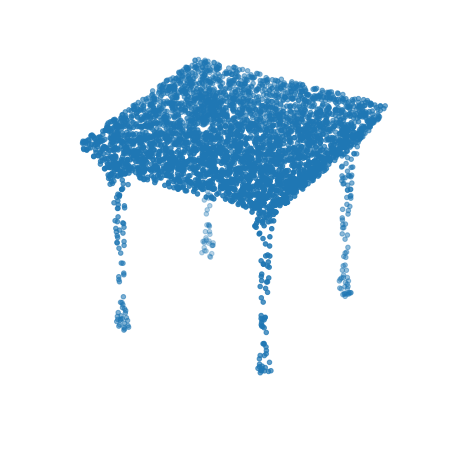

In [ ]:
# sampled point cloud
points = mesh.sample(4096)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
# parse the entire dataset
def parse_dataset(num_points=4096):
    """
        parse the dataset and return one point cloud for each object, the list of label 
        and the class_map dict('index': label)
        in:   number of points
        out:  array: point clouds, array: labels, dict: class_map
    """

    points = []
    labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*0028.off"))
        test_files = glob.glob(os.path.join(folder, "test/*0028.off"))
        
        files = sorted(test_files+train_files)
        for f in files:
            points.append(trimesh.load(f).sample(num_points))
            labels.append(i)
        

    return (
        np.array(points),
        np.array(labels),
        class_map,
    )

In [ ]:
NUM_POINTS = 4096

points, labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: desk
processing class: bed
processing class: monitor
processing class: bathtub
processing class: chair
processing class: night_stand
processing class: table
processing class: toilet
processing class: sofa
processing class: dresser


In [ ]:
torch.save(points, 'points.pt')
torch.save(labels, 'labels.pt')
torch.save(CLASS_MAP, 'CLASS_MAP.pt')
files.download('points.pt') 
files.download('labels.pt') 
files.download('CLASS_MAP.pt') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Plot the sampled point cloud**

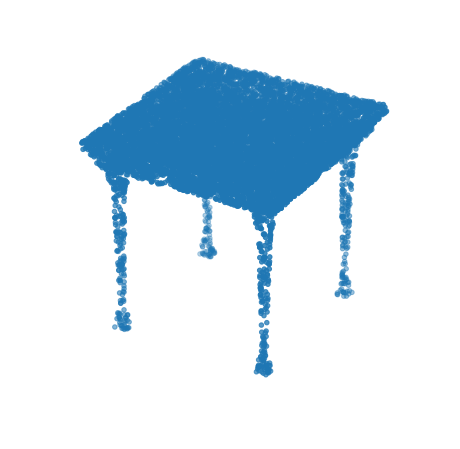

In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, 'table/train/table_0028.off'))
points = mesh.sample(10096)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()


device=torch.device("cuda:0")
mesh = IO().load_mesh(os.path.join(DATA_DIR, 'table/train/table_0028.off'), device=device)

verts=torch.Tensor(points)
rgb=torch.randn(verts.shape)


point_cloud = Pointclouds(points=[verts], features=[rgb])

# Siluette of the object from different perspectives

SoftSilhouetteShader -> render the siluette images

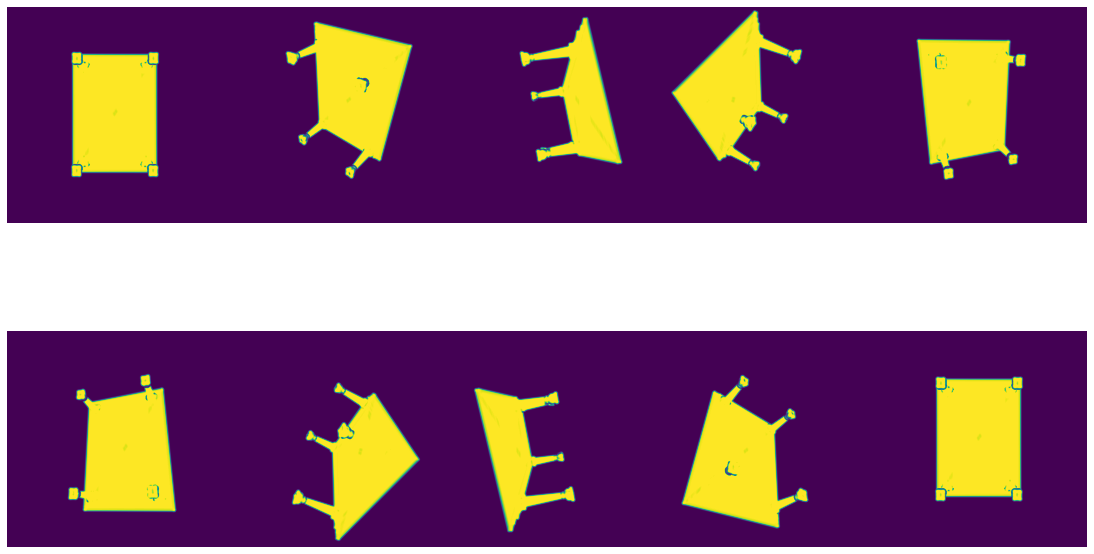

torch.Size([10, 512, 512, 4])


In [ ]:
num_views = 10

# make the scene centered in offset
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

# different projection (elev, azim)
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# control the light location
lights = PointLights(device=device)

# control the camera perspective pose
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...]) 

sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=512, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)
# render the mesh
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

meshes = mesh.extend(num_views)

silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

image_grid(silhouette_images.cpu().numpy(), rows=2, cols=5, rgb=False)
plt.show()

print(silhouette_images.shape)

# Those functions render the images 512x512

- **get_points_renderer**: *render the images from the points*
- **get_mesh_renderer**: *render the images from the mesh*

In [3]:
# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# that function render the pointcloud
def get_points_renderer(
    image_size=512, device=None, radius=0.01, background_color=(1, 1, 1)
):
    """ source: https://github.com/learning3d/assignment1/blob/master/starter/utils.py
    Returns a Pytorch3D renderer for point clouds.
    Args:
        image_size (int): The rendered image size.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
        radius (float): The radius of the rendered point in NDC.
        background_color (tuple): The background color of the rendered image.
    
    Returns:
        PointsRenderer.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = PointsRasterizationSettings(image_size=image_size, radius=radius,)
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(raster_settings=raster_settings),
        compositor=AlphaCompositor(background_color=background_color),
    )
    return renderer

def get_mesh_renderer(image_size=512, lights=None, device=None):
    """ source: https://github.com/learning3d/assignment1/blob/master/starter/utils.py
    Returns a Pytorch3D Mesh Renderer.
    Args:
        image_size (int): The rendered image size.
        lights: A default Pytorch3D lights object.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = RasterizationSettings(
        image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=HardPhongShader(device=device, lights=lights),
    )
    return renderer

# Render Images from ModelNet40
**Specifically, we add a sinusoidal texture based on the current position of the point in the space. Thus, the color is  **

In [4]:
device=torch.device("cuda:0")
mesh = IO().load_mesh(os.path.join(DATA_DIR, 'table/train/table_0028.off'), device=device)

In [86]:
num_img=4

# make the scene centered in offset
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

# add texture rgb to the object
t=verts
t=torch.abs(t.min())+t
#a = torch.sin(torch.randn((t.shape))) # model_net_texrandn
a = torch.sin(t) # model_net_texsin
c = ((a/(torch.zeros((t.shape)).to(device)+2))+0.5).to(device)
c=c[None,:]
verts_rgb = c

mesh.textures = TexturesVertex(verts_features=verts_rgb) 

renders = []
angles = np.linspace(0,360,num_img)
for i, angle in enumerate(tqdm(angles)):
    R, T = pytorch3d.renderer.look_at_view_transform(dist=5.0, elev=2, azim=angle)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
    renderer=get_mesh_renderer(device=device)
    rend = renderer(mesh, cameras=cameras)
    rend = rend.cpu().numpy()
    renders.append(rend[0])

100%|██████████| 4/4 [00:00<00:00, 29.05it/s]


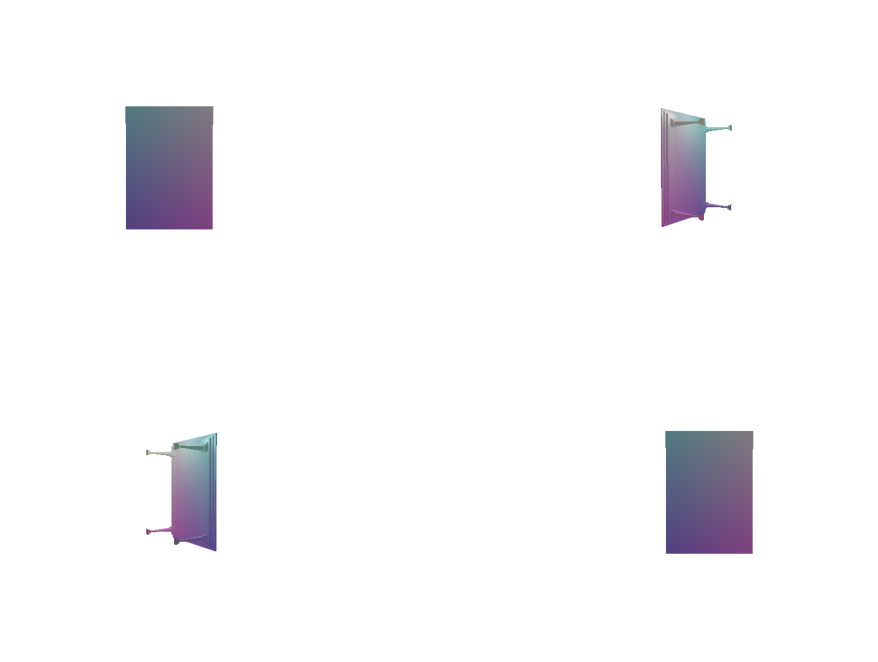

In [87]:
image_grid(torch.Tensor(renders).numpy(), rows=2, cols=2, rgb=True)
plt.show()

In [ ]:
images = []
for i, r in enumerate(renders):
    image = Image.fromarray((r * 255).astype(np.uint8))
    draw = ImageDraw.Draw(image)
    images.append(np.array(image))

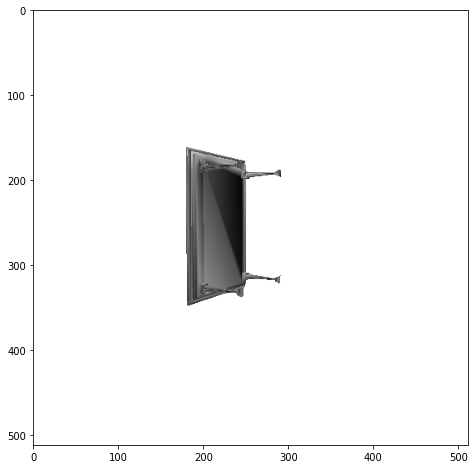

In [ ]:
plt.figure(figsize=(8,8))

plt.imshow(images[3])

In [109]:
# image generator
def image_gen(renders):
  '''
        Generate from the renders a list of images
        in:     renders, list of array (n_views, 512, 512, 3)
        out:    images, list of PIL images (n_views, 512, 512, 3)

   '''
  images = []
  for i, r in enumerate(renders):
      image = Image.fromarray((r * 255).astype(np.uint8))
      draw = ImageDraw.Draw(image)
      images.append(np.array(image))
  return images

# render generator
def render_gen(currentfolder,device=device):
  '''
    Generate from the mesh a list of render from different poses
    in:     currentfolder, Str
    out:    renders, list of array (n_views, 512, 512, 3)

  '''
  # setup
  device=torch.device("cuda:0")
  mesh = IO().load_mesh(currentfolder, device=device)
  # number of views
  num_img=4

  # make the scene centered in offset
  verts = mesh.verts_packed()
  N = verts.shape[0]
  center = verts.mean(0)
  scale = max((verts - center).abs().max(0)[0])
  mesh.offset_verts_(-center)
  mesh.scale_verts_((1.0 / float(scale)));

  # add texture rgb to the object
  t=verts
  t=torch.abs(t.min())+t
  #a = torch.sin(torch.randn((t.shape))) # model_net_texrandn
  a = torch.sin(t) # model_net_texsin
  c = ((a/(torch.zeros((t.shape))+2))+0.5).to(device)
  c=c[None,:] # with this trick we add a texture to the mesh even if there is no texture
  verts_rgb = torch.zeros([1, mesh.verts_list()[0].shape[0], 3], device=device)+c
  mesh.textures = TexturesVertex(verts_features=verts_rgb) 

  renders = []
  angles = np.linspace(0,360,num_img)
  for i, angle in enumerate(tqdm(angles)):
      R, T = pytorch3d.renderer.look_at_view_transform(dist=2.8, elev=2, azim=angle)
      cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
      renderer=get_mesh_renderer(device=device)
      rend = renderer(mesh, cameras=cameras)
      rend = rend.cpu().numpy()
      renders.append(rend[0])

  return renders

# parse the entire dataset
def parse_dataset(num_points=4096):
    '''
        Given the dataset this function parse the folders and bring
        one object for each category. From each mesh genrate:
            - the uniform point cloud
                                    -> stored in the list: points
            - the renders of the object from different views
                                    -> stored in the list: images_obj
        Additionally, we store the label of each object as an int. From
        the label we can backtrack to the id of the object from the
        dict class_map.  class_map[label] => id_object
            es. class_map[10] => radio

        in:     num_points, Int
        out:    points, Array (n_obj, num_points, 3)
                labels, Array (n_obj, )
                images_obj, Array (n_obj, 512, 512, 3)
                class_map, dict(label='id_object')

    '''
    points = []
    labels = []
    images_obj = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*0001.off"))
        test_files = glob.glob(os.path.join(folder, "test/*0001.off"))
        
        files = sorted(test_files+train_files)
        for f in files:
            points.append(trimesh.load(f).sample(num_points))
            labels.append(i)
            images_obj.append(image_gen(render_gen(f)))

    return (
        np.array(points),
        np.array(labels),
        np.array(images_obj),
        class_map
        )

In [110]:
NUM_POINTS = 4096

points, labels, images_obj, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: radio


100%|██████████| 4/4 [00:00<00:00, 33.01it/s]

processing class: cup



100%|██████████| 4/4 [00:00<00:00, 33.21it/s]


processing class: wardrobe


100%|██████████| 4/4 [00:00<00:00, 35.83it/s]


processing class: vase


100%|██████████| 4/4 [00:00<00:00, 37.85it/s]


processing class: person


100%|██████████| 4/4 [00:00<00:00, 32.15it/s]


processing class: range_hood


100%|██████████| 4/4 [00:00<00:00, 43.43it/s]


processing class: sink


100%|██████████| 4/4 [00:00<00:00, 44.05it/s]


processing class: table


100%|██████████| 4/4 [00:00<00:00, 51.03it/s]


processing class: guitar


100%|██████████| 4/4 [00:00<00:00, 49.68it/s]


processing class: bed


100%|██████████| 4/4 [00:00<00:00, 44.45it/s]


processing class: piano


100%|██████████| 4/4 [00:00<00:00, 46.54it/s]


processing class: tent


100%|██████████| 4/4 [00:00<00:00, 50.51it/s]


processing class: door


100%|██████████| 4/4 [00:00<00:00, 52.61it/s]


processing class: lamp


100%|██████████| 4/4 [00:00<00:00, 29.63it/s]


processing class: plant


100%|██████████| 4/4 [00:00<00:00, 13.00it/s]


processing class: monitor


100%|██████████| 4/4 [00:00<00:00, 15.93it/s]


processing class: tv_stand


100%|██████████| 4/4 [00:00<00:00, 17.46it/s]


processing class: curtain


100%|██████████| 4/4 [00:00<00:00, 19.49it/s]


processing class: laptop


100%|██████████| 4/4 [00:00<00:00, 40.56it/s]


processing class: bathtub


100%|██████████| 4/4 [00:00<00:00, 21.05it/s]


processing class: dresser


100%|██████████| 4/4 [00:00<00:00, 25.68it/s]


processing class: glass_box


100%|██████████| 4/4 [00:00<00:00, 27.33it/s]


processing class: xbox


100%|██████████| 4/4 [00:00<00:00, 22.01it/s]


processing class: car


100%|██████████| 4/4 [00:00<00:00, 11.98it/s]


processing class: flower_pot


100%|██████████| 4/4 [00:00<00:00, 47.63it/s]


processing class: chair


100%|██████████| 4/4 [00:00<00:00, 31.17it/s]


processing class: bottle


100%|██████████| 4/4 [00:00<00:00, 42.06it/s]


processing class: stairs


100%|██████████| 4/4 [00:00<00:00, 46.93it/s]


processing class: bowl


100%|██████████| 4/4 [00:00<00:00, 49.21it/s]


processing class: stool


100%|██████████| 4/4 [00:00<00:00, 40.76it/s]


processing class: night_stand


100%|██████████| 4/4 [00:00<00:00, 14.61it/s]


processing class: bookshelf


100%|██████████| 4/4 [00:00<00:00, 46.18it/s]


processing class: bench


100%|██████████| 4/4 [00:00<00:00, 50.16it/s]


processing class: toilet


100%|██████████| 4/4 [00:00<00:00, 54.45it/s]


processing class: airplane


100%|██████████| 4/4 [00:00<00:00, 15.57it/s]


processing class: sofa


100%|██████████| 4/4 [00:00<00:00, 48.10it/s]


processing class: mantel


100%|██████████| 4/4 [00:00<00:00, 54.30it/s]


processing class: desk


100%|██████████| 4/4 [00:00<00:00, 51.61it/s]


processing class: cone


100%|██████████| 4/4 [00:00<00:00, 43.90it/s]


processing class: keyboard


100%|██████████| 4/4 [00:00<00:00, 17.92it/s]


{0: 'radio', 1: 'cup', 2: 'wardrobe', 3: 'vase', 4: 'person', 5: 'range_hood', 6: 'sink', 7: 'table', 8: 'guitar', 9: 'bed', 10: 'piano', 11: 'tent', 12: 'door', 13: 'lamp', 14: 'plant', 15: 'monitor', 16: 'tv_stand', 17: 'curtain', 18: 'laptop', 19: 'bathtub', 20: 'dresser', 21: 'glass_box', 22: 'xbox', 23: 'car', 24: 'flower_pot', 25: 'chair', 26: 'bottle', 27: 'stairs', 28: 'bowl', 29: 'stool', 30: 'night_stand', 31: 'bookshelf', 32: 'bench', 33: 'toilet', 34: 'airplane', 35: 'sofa', 36: 'mantel', 37: 'desk', 38: 'cone', 39: 'keyboard'}


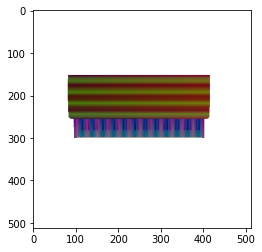

In [95]:
plt.imshow(images_obj[10][0])
print(CLASS_MAP)

In [111]:
# save the files
!mkdir model_net_csinrandn
torch.save(points, 'model_net_csinrandn/points.pt')
torch.save(labels, 'model_net_csinrandn/labels.pt')
torch.save(images_obj, 'model_net_csinrandn/images_obj.pt')
torch.save(CLASS_MAP, 'model_net_csinrandn/CLASS_MAP.pt')
!zip -r ./model_net_csinrandn.zip ./model_net_csinrandn

  adding: model_net_csinrandn/ (stored 0%)
  adding: model_net_csinrandn/labels.pt (deflated 56%)
  adding: model_net_csinrandn/points.pt (deflated 31%)
  adding: model_net_csinrandn/CLASS_MAP.pt (deflated 44%)
  adding: model_net_csinrandn/images_obj.pt (deflated 95%)


In [52]:
# download the files
files.download('points.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
files.download('labels.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
files.download('images_obj.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
files.download('CLASS_MAP.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***test this add to the dataset the file object found online***

In [ ]:
verts, faces, _ = load_obj("airboat.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)

In [ ]:
c=torch.abs(torch.sin(torch.stack([torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0])],dim=1))).to(device)
c=c[None,:] # with this trick we add a texture to the mesh even if there is no texture
verts_rgb = torch.zeros([1, mesh.verts_list()[0].shape[0], 3], device=device)+c
mesh.textures = TexturesVertex(verts_features=verts_rgb) 

In [ ]:
num_img=10

# make the scene centered in offset
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));


renders = []
angles = np.linspace(0,360,num_img)
for i, angle in enumerate(tqdm(angles)):
    R, T = pytorch3d.renderer.look_at_view_transform(dist=1.8, elev=2, azim=angle)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
    renderer=get_mesh_renderer(device=device)
    rend = renderer(mesh, cameras=cameras)
    rend = rend.cpu().numpy()
    renders.append(rend[0])

100%|██████████| 10/10 [00:00<00:00, 31.66it/s]


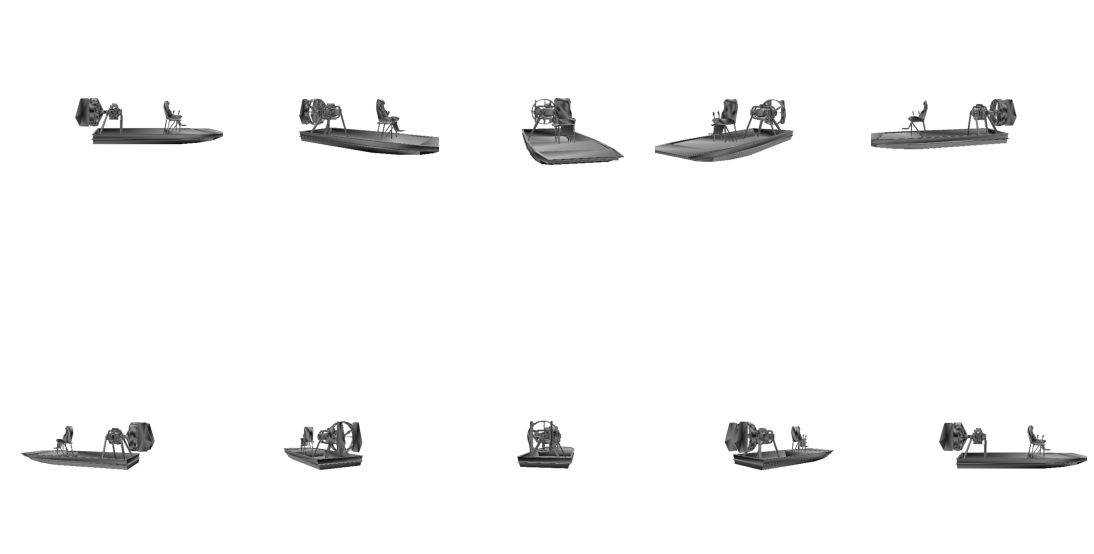

In [ ]:
image_grid(torch.Tensor(renders).numpy(), rows=2, cols=5, rgb=True)
plt.show()

In [ ]:
point_cloud = sample_points_from_meshes(mesh, 4096) # point cloud of the airboat

# ***Load the objects from shapenet***

In [112]:
DATA_DIR = tf.keras.utils.get_file(
    "val.zip",
    "http://shapenet.cs.stanford.edu/shapenet/obj-zip/SHREC16/val.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "val")

In [ ]:
DATA_DIR

'/root/.keras/datasets/val'

In [ ]:
glob.glob(DATA_DIR+'/02834778/*')

['/root/.keras/datasets/val/02834778/model_024940.obj',
 '/root/.keras/datasets/val/02834778/model_009011.obj',
 '/root/.keras/datasets/val/02834778/model_040852.obj',
 '/root/.keras/datasets/val/02834778/model_027730.obj',
 '/root/.keras/datasets/val/02834778/model_040587.obj',
 '/root/.keras/datasets/val/02834778/model_017610.obj']

In [ ]:
device=torch.device("cuda:0")
mesh = IO().load_mesh('/root/.keras/datasets/val/02834778/model_009011.obj', device=device)

/usr/local/lib/python3.8/dist-packages/pytorch3d/io/utils.py:65: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [60]:
num_img=10

# make the scene centered in offset
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

# add texture rgb to the object
#c = torch.abs(torch.sin(torch.stack([torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0])],dim=1))).to(device)
t=verts
t=torch.abs(t.min())+t
a = torch.sin(torch.randn((t.shape)))
c = ((a/(torch.zeros((t.shape))+2))+0.5).to(device)
c=c[None,:]
verts_rgb = c
# try to add colors but does not works
#import igl
#v,f=igl.read_triangle_mesh(os.path.join(DATA_DIR, 'table/train/table_0028.off'))
#vs=np.array([0])
#vt=np.arange(len(v))
#d=igl.exact_geodesic(v,f,vs,vt)
#c=np.sin(d)
#verts_rgb=torch.stack((torch.Tensor(c)*10,torch.Tensor(c)*10,torch.Tensor(c)*10), dim = 1).to(device)
#verts_rgb=verts_rgb[None,:]

mesh.textures = TexturesVertex(verts_features=verts_rgb) 

renders = []
angles = np.linspace(0,360,num_img)
for i, angle in enumerate(tqdm(angles)):
    R, T = pytorch3d.renderer.look_at_view_transform(dist=2.8, elev=2, azim=angle)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
    renderer=get_mesh_renderer(device=device)
    rend = renderer(mesh, cameras=cameras)
    rend = rend.cpu().numpy()
    renders.append(rend[0])

100%|██████████| 10/10 [00:00<00:00, 35.39it/s]


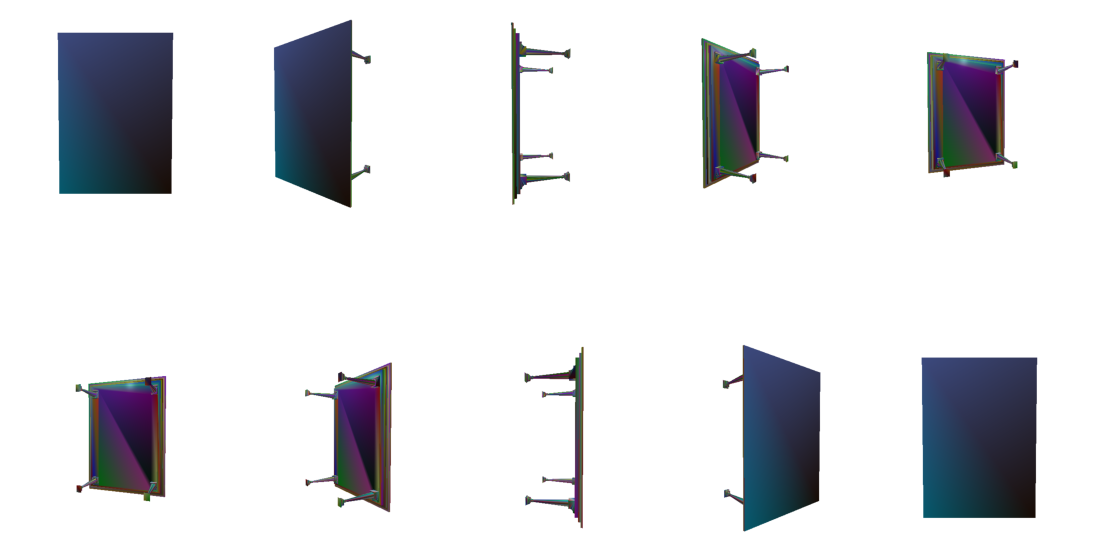

In [61]:
image_grid(torch.Tensor(renders).numpy(), rows=2, cols=5, rgb=True)
plt.show()

In [113]:
# image generator
def image_gen(renders):

  images = []
  for i, r in enumerate(renders):
      image = Image.fromarray((r * 255).astype(np.uint8))
      draw = ImageDraw.Draw(image)
      images.append(np.array(image))
  return images

# render generator
def render_gen(currentfolder,device=device):
  # setup
  device=torch.device("cuda:0")
  mesh = IO().load_mesh(currentfolder, device=device)
  # number of views
  num_img=4

  # make the scene centered in offset
  verts = mesh.verts_packed()
  N = verts.shape[0]
  center = verts.mean(0)
  scale = max((verts - center).abs().max(0)[0])
  mesh.offset_verts_(-center)
  mesh.scale_verts_((1.0 / float(scale)));

  # add texture rgb to the object
  #c=torch.abs(torch.sin(torch.stack([torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0])],dim=1))).to(device)
  t=verts
  t=torch.abs(t.min())+t
  a = torch.sin(torch.randn((t.shape)))
  c = ((a/(torch.zeros((t.shape))+2))+0.5).to(device)
  #a = torch.sin(t)
  #c = ((a/(torch.zeros((t.shape)).to(device)+2))+0.5).to(device)
  c=c[None,:] # with this trick we add a texture to the mesh even if there is no texture
  verts_rgb = torch.zeros([1, mesh.verts_list()[0].shape[0], 3], device=device)+c
  mesh.textures = TexturesVertex(verts_features=verts_rgb) 

  renders = []
  angles = np.linspace(0,360,num_img)
  for i, angle in enumerate(tqdm(angles)):
      R, T = pytorch3d.renderer.look_at_view_transform(dist=2.8, elev=2, azim=angle)
      cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
      renderer=get_mesh_renderer(device=device)
      rend = renderer(mesh, cameras=cameras)
      rend = rend.cpu().numpy()
      renders.append(rend[0])

  return renders

# parse the entire dataset
def parse_dataset(num_points=4096):

    points = []
    labels = []
    images_obj = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]

        f = glob.glob(folder+'/*')[0]
        points.append(trimesh.load(f).sample(num_points))
        labels.append(i)
        images_obj.append(image_gen(render_gen(f)))

        

    return (
        np.array(points),
        np.array(labels),
        np.array(images_obj),
        class_map
        )

In [ ]:
print('number of object: ',len(glob.glob(DATA_DIR+'/*')))

number of object:  55


In [114]:
NUM_POINTS = 4096

points, labels, images_obj, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

/usr/local/lib/python3.8/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


processing class: 03325088


100%|██████████| 4/4 [00:00<00:00, 27.91it/s]


processing class: 02946921


/usr/local/lib/python3.8/dist-packages/pytorch3d/io/utils.py:65: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
100%|██████████| 4/4 [00:00<00:00, 30.24it/s]


processing class: 03636649


100%|██████████| 4/4 [00:00<00:00, 39.94it/s]


processing class: 03761084


100%|██████████| 4/4 [00:00<00:00, 44.17it/s]


processing class: 03001627


100%|██████████| 4/4 [00:00<00:00, 43.80it/s]


processing class: 04004475


100%|██████████| 4/4 [00:00<00:00, 37.64it/s]


processing class: 02691156


100%|██████████| 4/4 [00:00<00:00, 12.94it/s]


processing class: 02942699


100%|██████████| 4/4 [00:00<00:00, 60.55it/s]


processing class: 02958343


100%|██████████| 4/4 [00:00<00:00, 46.53it/s]


processing class: 03938244


100%|██████████| 4/4 [00:00<00:00, 61.51it/s]


processing class: 03991062


100%|██████████| 4/4 [00:00<00:00, 60.65it/s]


processing class: 03046257


100%|██████████| 4/4 [00:00<00:00, 55.24it/s]


processing class: 04090263


100%|██████████| 4/4 [00:00<00:00, 61.46it/s]


processing class: 02880940


100%|██████████| 4/4 [00:00<00:00, 59.22it/s]


processing class: 03261776


100%|██████████| 4/4 [00:00<00:00, 57.44it/s]


processing class: 04225987


100%|██████████| 4/4 [00:00<00:00, 59.86it/s]


processing class: 04074963


100%|██████████| 4/4 [00:00<00:00, 59.50it/s]


processing class: 02843684


100%|██████████| 4/4 [00:00<00:00, 61.24it/s]


processing class: 03207941


100%|██████████| 4/4 [00:00<00:00, 58.83it/s]


processing class: 02801938


100%|██████████| 4/4 [00:00<00:00, 60.46it/s]


processing class: 02876657


100%|██████████| 4/4 [00:00<00:00, 60.72it/s]


processing class: 03710193


100%|██████████| 4/4 [00:00<00:00, 60.28it/s]


processing class: 02871439


100%|██████████| 4/4 [00:00<00:00, 52.99it/s]


processing class: 03085013


100%|██████████| 4/4 [00:00<00:00, 48.65it/s]


processing class: 03337140


100%|██████████| 4/4 [00:00<00:00, 55.59it/s]


processing class: 03790512


100%|██████████| 4/4 [00:00<00:00,  8.42it/s]


processing class: 02818832


100%|██████████| 4/4 [00:00<00:00, 46.39it/s]


processing class: 04401088


100%|██████████| 4/4 [00:00<00:00, 49.79it/s]


processing class: 04379243


100%|██████████| 4/4 [00:00<00:00, 56.32it/s]


processing class: 03642806


100%|██████████| 4/4 [00:00<00:00, 54.06it/s]


processing class: 02828884


100%|██████████| 4/4 [00:00<00:00, 54.31it/s]


processing class: 02773838


100%|██████████| 4/4 [00:00<00:00, 52.76it/s]


processing class: 04330267


100%|██████████| 4/4 [00:00<00:00, 51.62it/s]


processing class: 03593526


100%|██████████| 4/4 [00:00<00:00, 48.49it/s]


processing class: 04554684


100%|██████████| 4/4 [00:00<00:00, 36.61it/s]


processing class: 02933112


100%|██████████| 4/4 [00:00<00:00, 37.50it/s]


processing class: 03948459


100%|██████████| 4/4 [00:00<00:00, 31.28it/s]


processing class: 02954340


100%|██████████| 4/4 [00:00<00:00, 40.27it/s]


processing class: 03759954


100%|██████████| 4/4 [00:00<00:00, 48.53it/s]


processing class: 03691459


100%|██████████| 4/4 [00:00<00:00, 19.45it/s]


processing class: 03513137


100%|██████████| 4/4 [00:00<00:00, 57.51it/s]


processing class: 03797390


100%|██████████| 4/4 [00:00<00:00, 42.93it/s]


processing class: 04460130


100%|██████████| 4/4 [00:00<00:00, 45.32it/s]


processing class: 03928116


100%|██████████| 4/4 [00:00<00:00, 42.19it/s]


processing class: 02834778


100%|██████████| 4/4 [00:00<00:00, 15.41it/s]


processing class: 04468005


100%|██████████| 4/4 [00:00<00:00,  6.64it/s]


processing class: 02924116


100%|██████████| 4/4 [00:00<00:00, 36.57it/s]


processing class: 03211117


100%|██████████| 4/4 [00:00<00:00, 44.80it/s]


processing class: 03624134


100%|██████████| 4/4 [00:00<00:00, 43.96it/s]


processing class: 04099429


100%|██████████| 4/4 [00:00<00:00, 53.24it/s]


processing class: 02808440


100%|██████████| 4/4 [00:00<00:00, 57.95it/s]


processing class: 03467517


100%|██████████| 4/4 [00:00<00:00,  9.10it/s]


processing class: 02747177


100%|██████████| 4/4 [00:00<00:00, 58.64it/s]


processing class: 04530566


100%|██████████| 4/4 [00:00<00:00, 51.76it/s]


processing class: 04256520


100%|██████████| 4/4 [00:00<00:00, 57.75it/s]


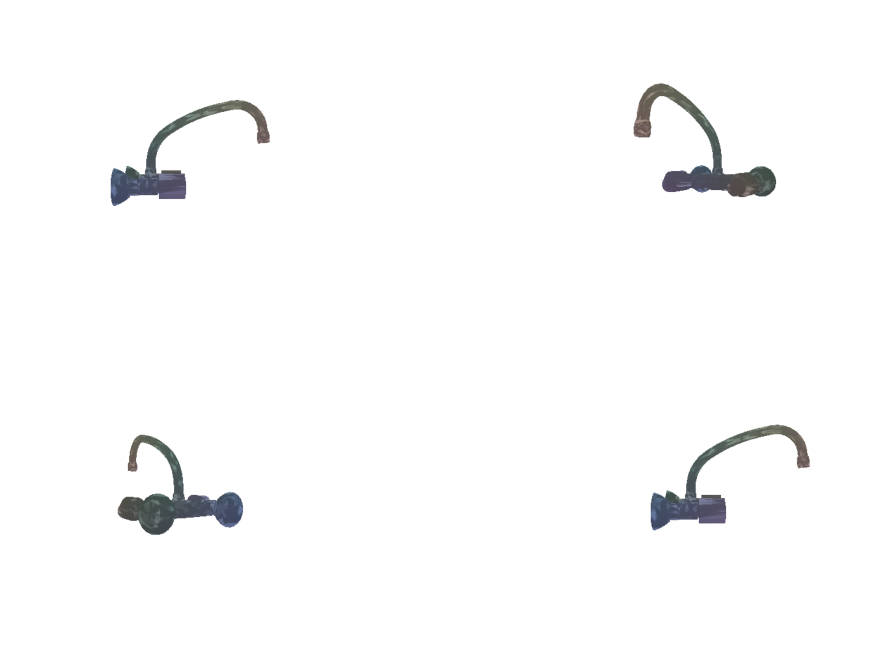

In [102]:
image_grid(images_obj[0][:,:,:,:3], rows=2, cols=2, rgb=True)
plt.show()

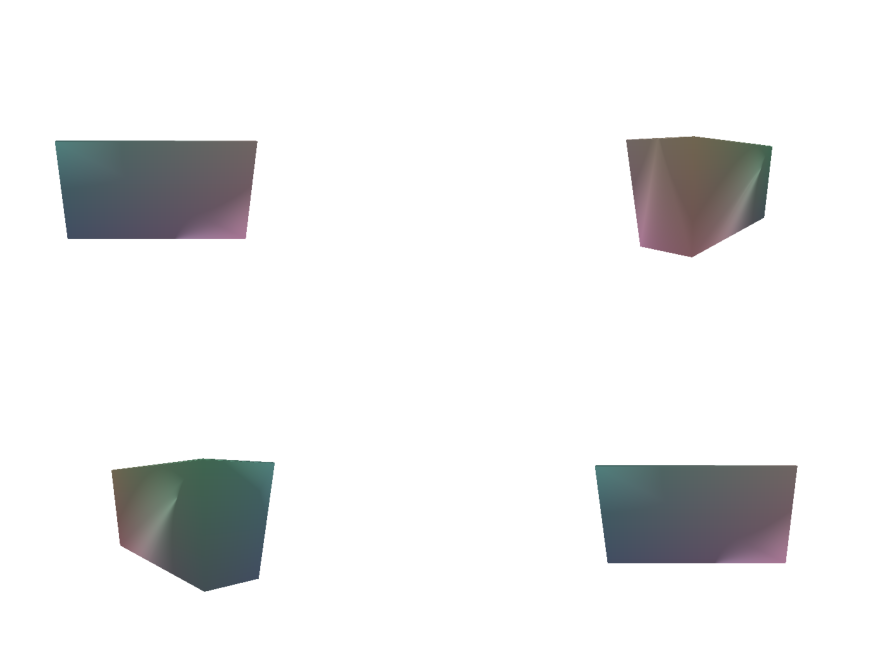

In [103]:
image_grid(images_obj[10][:,:,:,:3], rows=2, cols=2, rgb=True)
plt.show()

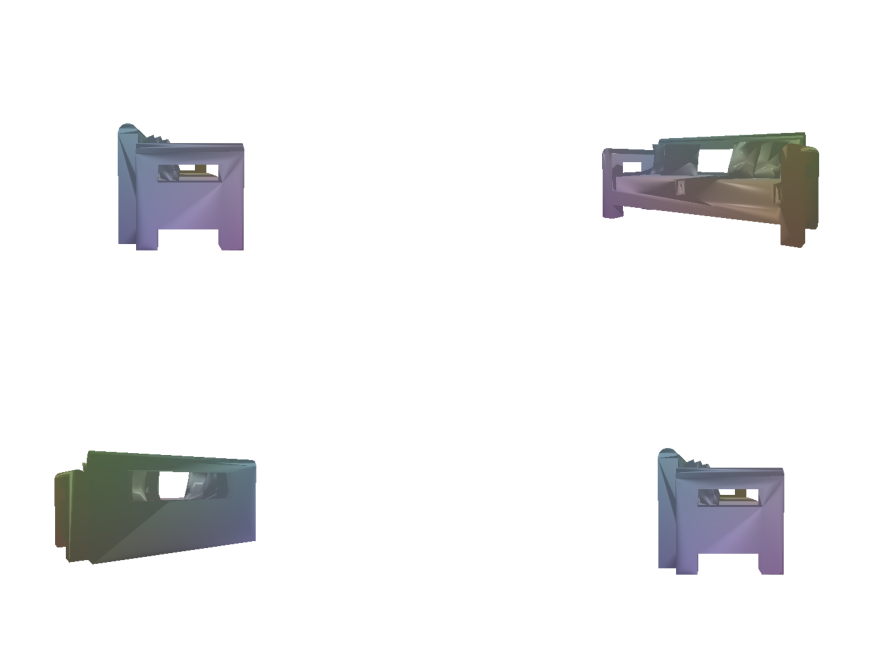

In [104]:
image_grid(images_obj[54][:,:,:,:3], rows=2, cols=2, rgb=True)
plt.show()

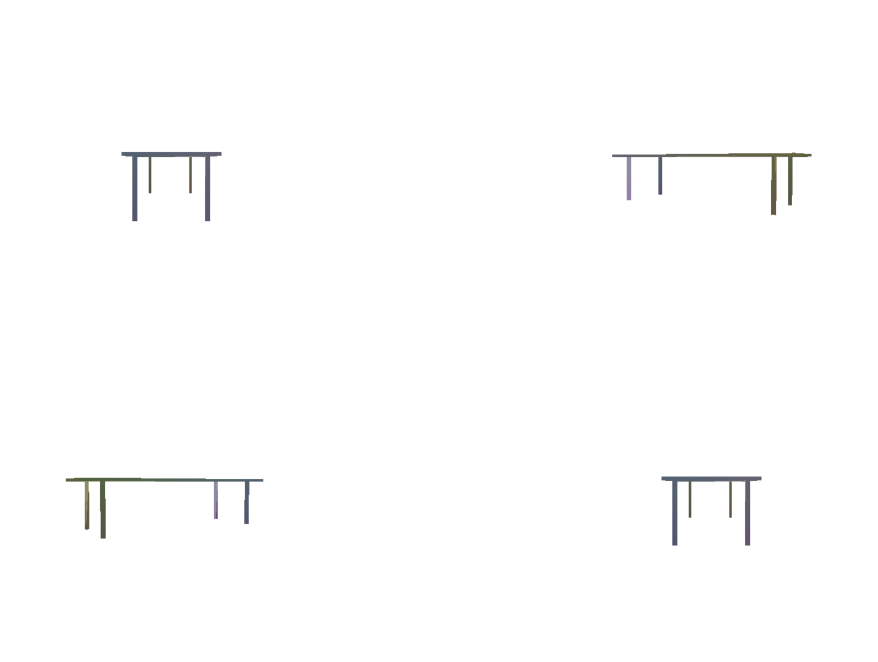

In [105]:
image_grid(images_obj[28][:,:,:,:3], rows=2, cols=2, rgb=True)
plt.show()

In [106]:
CLASS_MAP

{0: '03325088',
 1: '02946921',
 2: '03636649',
 3: '03761084',
 4: '03001627',
 5: '04004475',
 6: '02691156',
 7: '02942699',
 8: '02958343',
 9: '03938244',
 10: '03991062',
 11: '03046257',
 12: '04090263',
 13: '02880940',
 14: '03261776',
 15: '04225987',
 16: '04074963',
 17: '02843684',
 18: '03207941',
 19: '02801938',
 20: '02876657',
 21: '03710193',
 22: '02871439',
 23: '03085013',
 24: '03337140',
 25: '03790512',
 26: '02818832',
 27: '04401088',
 28: '04379243',
 29: '03642806',
 30: '02828884',
 31: '02773838',
 32: '04330267',
 33: '03593526',
 34: '04554684',
 35: '02933112',
 36: '03948459',
 37: '02954340',
 38: '03759954',
 39: '03691459',
 40: '03513137',
 41: '03797390',
 42: '04460130',
 43: '03928116',
 44: '02834778',
 45: '04468005',
 46: '02924116',
 47: '03211117',
 48: '03624134',
 49: '04099429',
 50: '02808440',
 51: '03467517',
 52: '02747177',
 53: '04530566',
 54: '04256520'}

In [115]:
# save the files
!mkdir shapenet_csinrandn
torch.save(points, 'shapenet_csinrandn/points.pt')
torch.save(labels, 'shapenet_csinrandn/labels.pt')
torch.save(images_obj, 'shapenet_csinrandn/images_obj.pt')
torch.save(CLASS_MAP, 'shapenet_csinrandn/CLASS_MAP.pt')
!zip -r ./shapenet_csinrandn.zip ./shapenet_csinrandn

  adding: shapenet_csinrandn/ (stored 0%)
  adding: shapenet_csinrandn/labels.pt (deflated 58%)
  adding: shapenet_csinrandn/points.pt (deflated 35%)
  adding: shapenet_csinrandn/CLASS_MAP.pt (deflated 52%)
  adding: shapenet_csinrandn/images_obj.pt (deflated 96%)


In [75]:
# download the files
files.download('points1.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
files.download('CLASS_MAP1.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
files.download('images_obj1.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
files.download('labels1.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Check another shapenet repo**

In [ ]:
# link for complete shapenet dataset
# https://s3.eu-central-1.amazonaws.com/avg-projects/shape_as_points/data/shapenet_psr.zip

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "shapenet_psr.zip",
    "https://s3.eu-central-1.amazonaws.com/avg-projects/shape_as_points/data/shapenet_psr.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "shapenet_psr")

45057785856/91398252796 [=============>................] - ETA: 54:02

**Extract the objects from the file object that I found online**

In [ ]:
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl

--2023-02-08 10:06:20--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[===================>]     155  --.-KB/s    in 0s      

2023-02-08 10:06:21 (29.7 MB/s) - ‘data/cow_mesh/cow.mtl’ saved [155/155]



In [ ]:
# image generator
def image_gen(renders):
  images = []
  for i, r in enumerate(renders):
      image = Image.fromarray((r * 255).astype(np.uint8))
      draw = ImageDraw.Draw(image)
      images.append(np.array(image))
  return images

# render generator
def render_gen(currentfolder,device=device):
  # setup
  device=torch.device("cuda:0")
  mesh = IO().load_mesh(currentfolder, device=device)
  # number of views
  num_img=10

  # make the scene centered in offset
  verts = mesh.verts_packed()
  N = verts.shape[0]
  center = verts.mean(0)
  scale = max((verts - center).abs().max(0)[0])
  mesh.offset_verts_(center)
  mesh.scale_verts_((1.0 / float(scale)));

  # add texture rgb to the object
  c=torch.abs(torch.sin(torch.stack([torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0])],dim=1))).to(device)
  c=c[None,:] # with this trick we add a texture to the mesh even if there is no texture
  verts_rgb = torch.zeros([1, mesh.verts_list()[0].shape[0], 3], device=device)+c
  mesh.textures = TexturesVertex(verts_features=verts_rgb) 

  renders = []
  angles = np.linspace(0,360,num_img)
  for i, angle in enumerate(tqdm(angles)):
      R, T = pytorch3d.renderer.look_at_view_transform(dist=2.8, elev=2, azim=angle)
      cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
      renderer=get_mesh_renderer(device=device)
      rend = renderer(mesh, cameras=cameras)
      rend = rend.cpu().numpy()
      renders.append(rend[0])

  return renders

# parse the entire dataset
def parse_dataset(num_points=4096):

    points = []
    labels = []
    images_obj = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*.obj"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder.split("/")[-1].split('.')[0])))
        class_map[i] = folder.split("/")[-1].split('.')[0]
        try:
          points.append(trimesh.load(folder).sample(num_points))
          labels.append(i)
          images_obj.append(image_gen(render_gen(folder)))
        except:
          pass

        

    return (
        np.array(points),
        np.array(labels),
        np.array(images_obj),
        class_map
        )

In [ ]:
NUM_POINTS = 4096

points1 , labels1, images_obj1, CLASS_MAP1 = parse_dataset(
    NUM_POINTS
)

/usr/local/lib/python3.8/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


processing class: teapot
processing class: cessna
processing class: sandal
processing class: magnolia
processing class: diamond


100%|██████████| 10/10 [00:00<00:00, 37.52it/s]


processing class: al
processing class: dodecahedron


100%|██████████| 10/10 [00:00<00:00, 46.25it/s]


processing class: icosahedron


100%|██████████| 10/10 [00:00<00:00, 61.76it/s]


processing class: cube


100%|██████████| 10/10 [00:00<00:00, 47.12it/s]


processing class: lamp
processing class: octahedron


100%|██████████| 10/10 [00:00<00:00, 62.85it/s]


processing class: airboat
processing class: gourd


100%|██████████| 10/10 [00:00<00:00, 60.90it/s]
/usr/local/lib/python3.8/dist-packages/pytorch3d/io/mtl_io.py:480: UserWarning: Texture file does not exist: ./cow_texture.png
  warnings.warn(msg)


processing class: cow


100%|██████████| 10/10 [00:00<00:00, 59.65it/s]


processing class: trumpet
processing class: symphysis
processing class: shuttle
processing class: roi


100%|██████████| 10/10 [00:00<00:00, 59.11it/s]


processing class: minicooper
processing class: humanoid_quad


100%|██████████| 10/10 [00:00<00:00, 57.09it/s]


processing class: skyscraper
processing class: violin_case
processing class: slot_machine
processing class: alfa147
processing class: humanoid_tri


100%|██████████| 10/10 [00:00<00:00, 55.14it/s]


processing class: tetrahedron


100%|██████████| 10/10 [00:00<00:00, 59.26it/s]


In [ ]:
torch.save(points1, 'points1.pt')
torch.save(labels1, 'labels1.pt')
torch.save(images_obj1, 'images_obj1.pt')
torch.save(CLASS_MAP1, 'CLASS_MAP1.pt')

In [ ]:
# download the files
files.download('points1.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('CLASS_MAP1.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('images_obj1.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('labels1.pt') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***DISTRIBUTION SCORE***

In [ ]:
import numpy as np
from numba import cuda

USE_64 = True

if USE_64:
    bits = 64
    np_type = np.float64
else:
    bits = 32
    np_type = np.float32

@cuda.jit("void(float{}[:, :], float{}[:, :])".format(bits, bits))
def distance_matrix(mat, out):
    m = mat.shape[0]
    n = mat.shape[1]
    i, j = cuda.grid(2)
    d = 0
    if i < m and j < m:
        for k in range(n):
            tmp = mat[i, k] - mat[j, k]
            d += tmp * tmp
        out[i, j] = d

def gpu_dist_matrix(mat):
    rows = mat.shape[0]

    block_dim = (16, 16)
    grid_dim = (int(rows/block_dim[0] + 1), int(rows/block_dim[1] + 1))

    stream = cuda.stream()
    mat2 = cuda.to_device(np.asarray(mat, dtype=np_type), stream=stream)
    out2 = cuda.device_array((rows, rows))
    distance_matrix[grid_dim, block_dim](mat2, out2)
    out = out2.copy_to_host(stream=stream)

    return out


# I generate the point cloud of two different objects

verts, faces, _ = load_obj("airboat.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
X=np.array(gpu_dist_matrix(point_cloud[0].cpu()))


verts, faces, _ = load_obj("al.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
Y=np.array(gpu_dist_matrix(point_cloud[0].cpu()))


verts, faces, _ = load_obj("sandal.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
Z=np.array(gpu_dist_matrix(point_cloud[0].cpu()))



<ipython-input-3-1173ebf96727>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


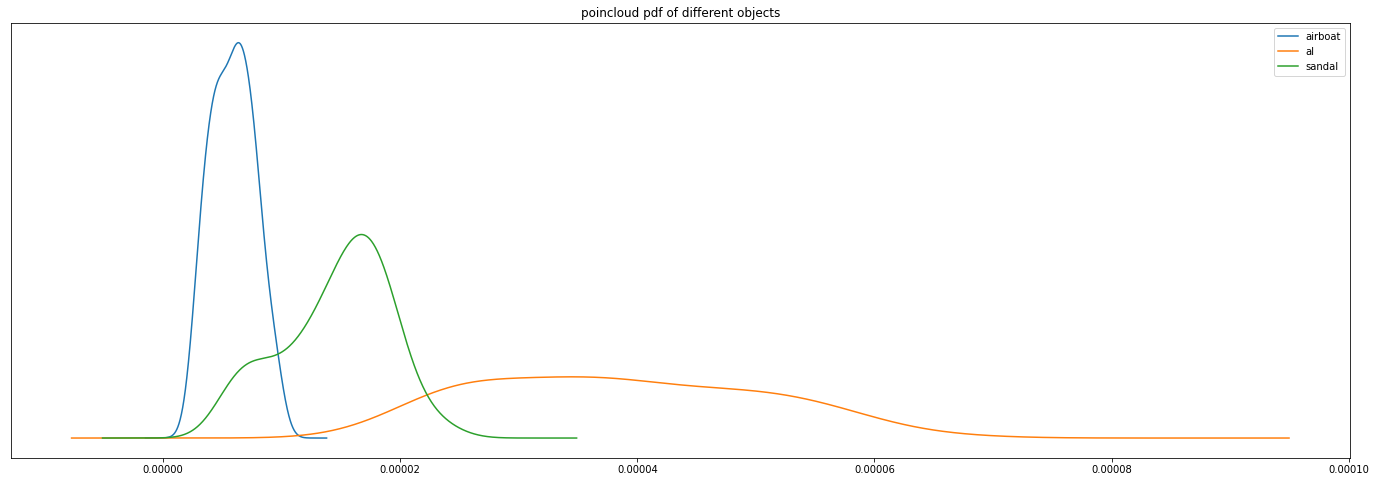

In [ ]:
s = pd.DataFrame({
    'airboat': [1/i.sum() for i in X],
    'al': [1/i.sum() for i in Y],
    'sandal': [1/i.sum() for i in Z],
  })

s.plot.kde(bw_method=0.4,figsize=(24,8),title='poincloud pdf of different objects')
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

# ***generate the object with point-e***

In [ ]:
!git clone -b multiview https://github.com/halixness/point-e
%cd point-e/

Cloning into 'point-e'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 151 (delta 37), reused 23 (delta 21), pack-reused 91
Receiving objects: 100% (151/151), 6.11 MiB | 11.73 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/point-e


In [ ]:
!pip install -e .
!pip install diffusers transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-iat5s_p3/clip_6878a31eb45945b7a097babc72d81618
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-iat5s_p3/clip_6878a31eb45945b7a097babc72d81618
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 

In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler


# setup cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

verts, faces, _ = load_obj("teapot.obj")

mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
# add texture
verts_rgb = torch.abs(torch.sin(torch.stack([torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0])],dim=1))).to(device)
verts_rgb = verts_rgb[None,:]
mesh.textures = TexturesVertex(verts_features=verts_rgb) 

--2023-02-07 13:13:00--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘teapot.obj’

teapot.obj          100%[===================>] 149.02K   230KB/s    in 0.6s    

2023-02-07 13:13:01 (230 KB/s) - ‘teapot.obj’ saved [152595/152595]



  0%|          | 0/4 [00:00<?, ?it/s]

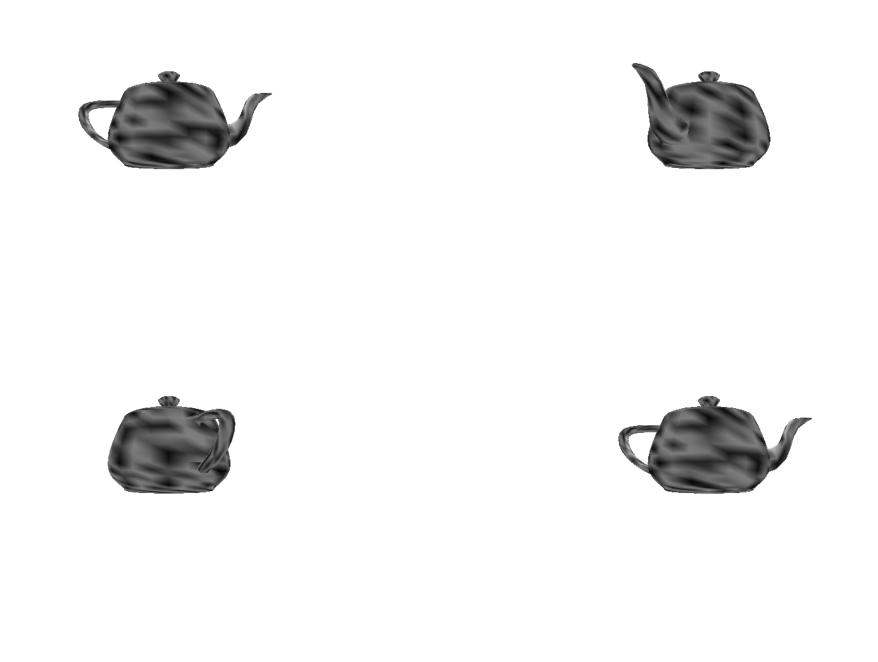

In [ ]:
num_img = 4

renders = []
angles = np.linspace(0,360,num_img)
for i, angle in enumerate(tqdm(angles)):
    R, T = pytorch3d.renderer.look_at_view_transform(dist=3.0, elev=2, azim=angle)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
    renderer=get_mesh_renderer(device=device)
    rend = renderer(mesh, cameras=cameras)
    rend = rend.cpu().numpy()
    renders.append(rend[0])
image_grid(torch.Tensor(renders).numpy(), rows=2, cols=2, rgb=True)
plt.show()

In [ ]:
images=image_gen(renders)

In [ ]:
len(images) #number of images

4

**from images to point cloud**

In [ ]:
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

MODEL_CONFIGS[base_name]["n_views"] = 1
MODEL_CONFIGS['upsample']["n_views"] = 1

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:10<00:00, 86.2MiB/s]


[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
downloading base checkpoint...


  0%|          | 0.00/1.25G [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
num_points = 1024

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=images))):
    samples = x

0it [00:00, ?it/s]

In [ ]:
print("size of the point cloud",samples.shape)

size of the point cloud torch.Size([1, 6, 4096])


In [ ]:
gen_pointcloud = samples[0, :3, :]
# reshape the point cloud
pc = sampler.output_to_point_clouds(samples)[0]
gen_pointcloud = torch.Tensor(pc.coords)
print('shape: ',gen_pointcloud.shape)

shape:  torch.Size([4096, 3])


In [ ]:
original = sample_points_from_meshes(mesh, num_samples=4096).cpu()[0]
original = original.permute(1, 0)
blacks = torch.zeros((3, original.shape[1]))
original = torch.cat((original, blacks), 0).unsqueeze(0).cpu()
pc = sampler.output_to_point_clouds(original)[0]
original = torch.Tensor(pc.coords)

print('shape: ',original.shape)

shape:  torch.Size([4096, 3])


In [ ]:
# generate the distance matrix between each pair of variables
X=np.array(gpu_dist_matrix(original.cpu()))

# generate the distance matrix between each pair of variables
Y=np.array(gpu_dist_matrix(gen_pointcloud.cpu()))


In [ ]:
''' train the KernelDensity

from sklearn.neighbors import KernelDensity
kde_o = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
kde_g = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(Y)
'''

This step is important to center the two pointcloud

In [ ]:
XX=np.multiply(((Y).max()/(X).max()),X)
#YY=np.multiply(((X).max()/(Y).max()),Y)

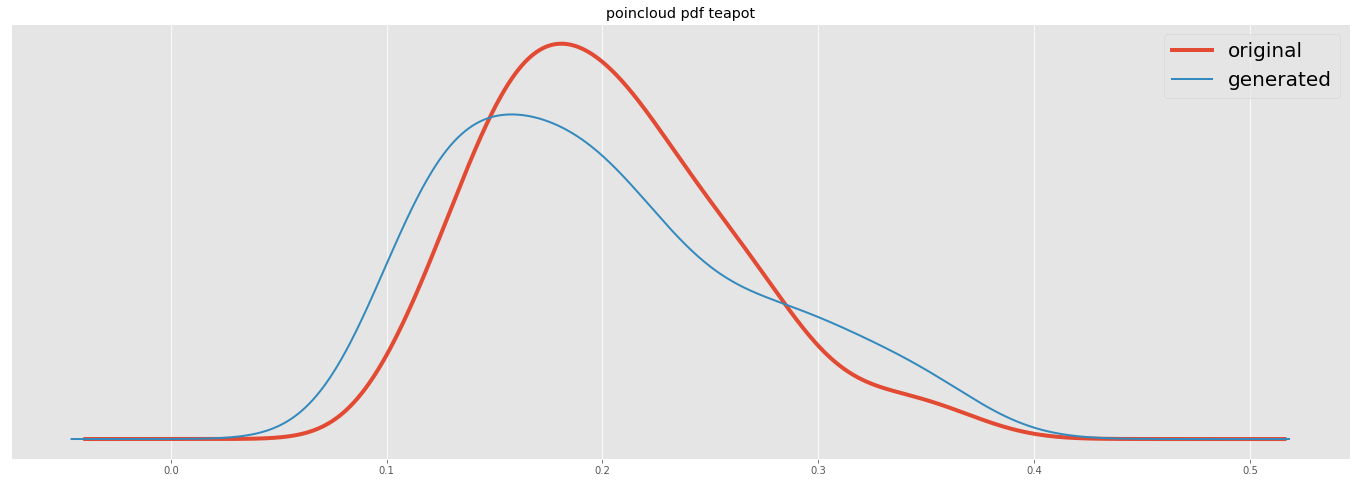

In [ ]:
# generate the plot
s = pd.DataFrame({
    'original': [i.max() for i in XX],
    'generated': [i.max() for i in Y],
  })


plt.style.use('ggplot')
s['original'].plot.kde(bw_method=0.4,figsize=(24,8),legend="original",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 4).legend(fontsize=20, loc="upper right")
s['generated'].plot.kde(bw_method=0.4,figsize=(24,8),legend="generated",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

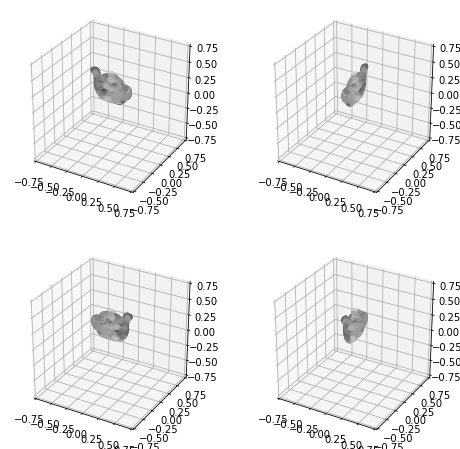

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

Now I try to add different object to check the distributions

In [ ]:
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl

--2023-02-07 16:05:14--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K   388KB/s    in 0.8s    

2023-02-07 16:05:16 (388 KB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2023-02-07 16:05:16--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[========

In [ ]:
v, f, _ = load_obj("data/cow_mesh/cow.obj")

m = Meshes(verts=[v], faces=[f.verts_idx]).to(device)
# add texture
verts_rgb = torch.abs(torch.sin(torch.stack([torch.arange(0,m.verts_list()[0].shape[0]),torch.arange(0,m.verts_list()[0].shape[0]),torch.arange(0,m.verts_list()[0].shape[0])],dim=1))).to(device)
verts_rgb = verts_rgb[None,:]
m.textures = TexturesVertex(verts_features=verts_rgb) 

In [ ]:
o_new = sample_points_from_meshes(m, num_samples=4096).cpu()[0]
o_new = o_new.permute(1, 0)
blacks = torch.zeros((3, o_new.shape[1]))
o_new = torch.cat((o_new, blacks), 0).unsqueeze(0).cpu()
pc = sampler.output_to_point_clouds(o_new)[0]
o_new = torch.Tensor(pc.coords)

print('shape: ',o_new.shape)

# generate the distance matrix between each pair of variables
O_NEW=np.array(gpu_dist_matrix(o_new.cpu()))

O_NEW = np.multiply(((Y).max()/(O_NEW).max()),O_NEW)

shape:  torch.Size([4096, 3])


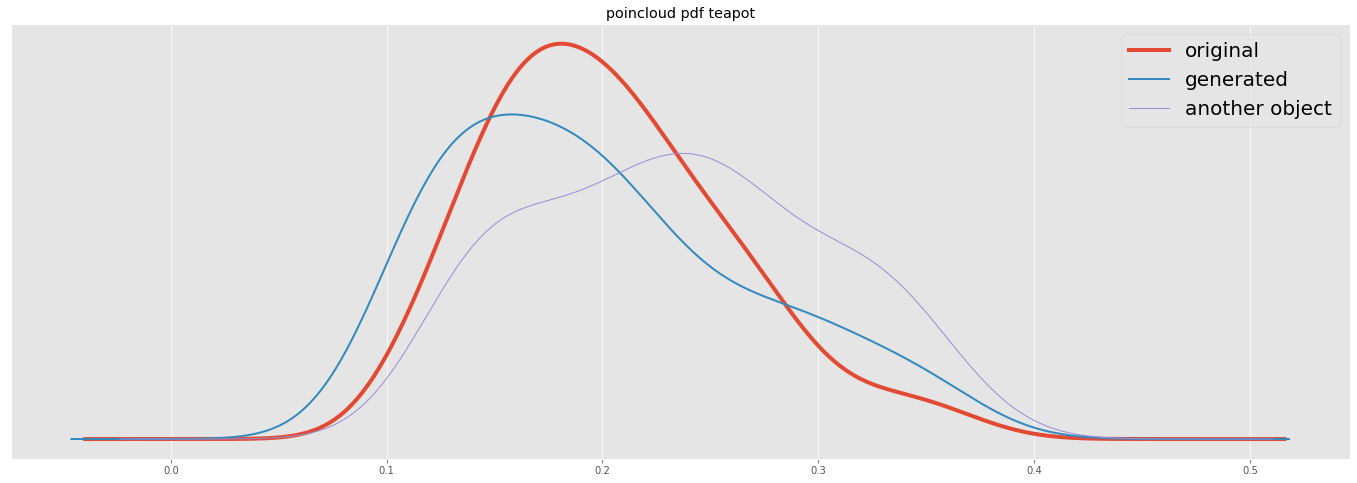

In [ ]:
# generate the plot
s = pd.DataFrame({
    'original': [i.max() for i in XX],
    'generated': [i.max() for i in Y],
    'another object': [i.max() for i in O_NEW],
  })


plt.style.use('ggplot')
s['original'].plot.kde(bw_method=0.4,figsize=(24,8),legend="original",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 4).legend(fontsize=20, loc="upper right")
s['generated'].plot.kde(bw_method=0.4,figsize=(24,8),legend="generated",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
s['another object'].plot.kde(bw_method=0.4,figsize=(24,8),legend="another object",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 1).legend(fontsize=20, loc="upper right")
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

***Chamfer Distance***

Chamfer Distance (CD) is a evaluation metric for two point clouds. It takes the distance of each points into account. For each point in each cloud, CD finds the nearest point in the other point set, and sums the square of distance up. It is utilized in Shapenet's shape reconstruction challenge.



In [ ]:
loss_chamfer, _ = chamfer_distance(original.cpu()[None,:], gen_pointcloud.cpu()[None,:])

In [ ]:
print('loss chamfer distance: ',loss_chamfer)

loss chamfer distance:  tensor(0.4227)
